In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading in the dataset and viewing the first few rows
df = pd.read_csv('cleaned_fraud.txt')
df.head()

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,347788,11.945973,7.775082,0.262675,1.0,1.0,1.0,1.0,0.0
1,845764,39.264472,24.749645,1.956956,1.0,0.0,0.0,0.0,0.0
2,230977,1.367472,3.131729,0.572104,0.0,1.0,0.0,1.0,0.0
3,962271,31.484941,0.161098,3.648510,1.0,0.0,0.0,1.0,0.0
4,154305,5.311520,3.537440,6.569696,1.0,1.0,0.0,1.0,1.0


In [3]:
# Removing unwanted columns 
df = df.drop(columns=['Unnamed: 0'])

# Checking KNN Assumptions

In [4]:
# Checking how balanced the outcome variable is
df.fraud.value_counts()

fraud
0.0    8944
1.0     672
Name: count, dtype: int64

In [5]:
# Checking the positivity rate to see if the outcome class is unbalanced
positivity_rate = 672/len(df)
print(positivity_rate)

0.06988352745424292


In [6]:
# Checking the shape of the df, to see how many rows and features
df.shape

(9616, 8)

In [7]:
# Splitting the df into features and outcome variable
x = df.drop(columns=['fraud'])
y = df[['fraud']]

# Train Test Split

In [8]:
# Splitting the features and outcome variable into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# SMOTE

In [9]:
# Checking the counts in the outcome variable for the training data
y_train.value_counts()

fraud
0.0      7156
1.0       536
Name: count, dtype: int64

In [10]:
# Creating SMOTE model
sm = SMOTE(random_state=1, sampling_strategy= 'minority')

# Fitting and resampling the training data
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

# Checking the counts of the outcome variable for the training data
y_train_res.value_counts()

fraud
0.0      7156
1.0      7156
Name: count, dtype: int64

# Scaling

In [11]:
# Creating a standard scaler model
scaler = StandardScaler()

# Fitting the standard scaler to the training data and transforming it
x_train_scaled = scaler.fit_transform(x_train_res)

# Transforming the testing data with the standard scaler
x_test_scaled = scaler.transform(x_test)

# KNN Model

In [12]:
# Creating a knn classifier
model = KNeighborsClassifier(n_neighbors=10)

# Fitting the classifier to the training data
model.fit(x_train_scaled, y_train_res)

KNeighborsClassifier(n_neighbors=10)

In [13]:
# Getting the accuracy score on the training and test data
print('Train score')
print(model.score(x_train_scaled, y_train_res))
print('Test score')
print(model.score(x_test_scaled, y_test))

Train score
0.9967160424818334
Test score
0.9896049896049897


In [14]:
# Getting the predictions for the x_train_scaled
y_pred_train = model.predict(x_train_scaled)

# Getting the prediction for the x_test_scaled
y_pred_test = model.predict(x_test_scaled)

In [15]:
# Getting the accuracy score for the testing data
model_accuracy_score = accuracy_score(y_test, y_pred_test)
print('The accuracy score is ' + str(model_accuracy_score))

# Getting the recall score for the testing data
model_recall_score = recall_score(y_test, y_pred_test)
print('The recall score is ' + str(model_recall_score))

# Getting the precision score for the testing data
model_precision_score = precision_score(y_test, y_pred_test)
print('The precision score is ' + str(model_precision_score))

# Getting the f1 score for the testing data
model_f1_score = f1_score(y_test, y_pred_test)
print('The f1 score is ' + str(model_f1_score))

The accuracy score is 0.9896049896049897
The recall score is 0.9926470588235294
The precision score is 0.8766233766233766
The f1 score is 0.9310344827586207


In [17]:
# Creating a confusion matrix to show the TN, FP, FN , TP
model_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test), index=['Not Fraud', 'Fraud'], 
                                     columns=['Predicted Not Fraud', 'Predicted Fraud'])

model_confusion_matrix

,Predicted Not Fraud,Predicted Fraud
Not Fraud,1769,19
Fraud,1,135


# Hyperparameter Tuning

In [18]:
# Finding the best value for k to maximise recall score
accuracies = []
for k in range(1,101):
    test_classifier = KNeighborsClassifier(n_neighbors=k)
    test_classifier.fit(x_train_scaled, y_train_res)
    y_pred = test_classifier.predict(x_test_scaled)
    accuracies.append(recall_score(y_test, y_pred))

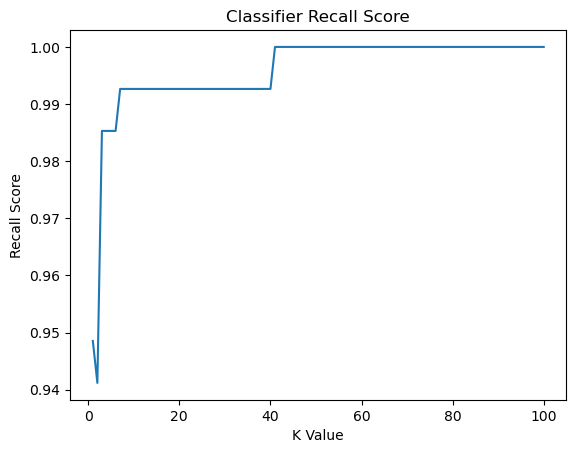

In [19]:
# Visualising the best value for k
k_list = range(1, 101)

plt.plot(k_list, accuracies)
plt.title('Classifier Recall Score')
plt.xlabel('K Value')
plt.ylabel('Recall Score')
plt.show()

In [20]:
# Finding the index of the max accuracies in the list
max_acc = accuracies.index(max(accuracies))

# Using the index to get the best value for K
best_k = k_list[max_acc]
print(best_k)

41


# KNN Model #2

In [21]:
# Creating a second model with the optimal k value
model_2 = KNeighborsClassifier(n_neighbors=best_k)

# Fitting the model with the training data
model_2.fit(x_train_scaled, y_train_res)

KNeighborsClassifier(n_neighbors=41)

# Evaluating KNN Model #2

In [22]:
# Calculating the score for the train and test data
print('Train score')
print(model_2.score(x_train_scaled, y_train_res))
print('Test score')
print(model_2.score(x_test_scaled, y_test))

Train score
0.9903577417551704
Test score
0.9766112266112266


In [23]:
# Getting the prediction on the training and test data from model 2
y_pred_train_2 = model_2.predict(x_train_scaled)
y_pred_test_2 = model_2.predict(x_test_scaled)

In [24]:
# Getting the accuracy score of the model on the testing data
accuracy_2 = accuracy_score(y_test, y_pred_test_2)
print('Accuracy score is ' + str(accuracy_2))

# Getting the precision score of the model on the testing data
precision_2 = precision_score(y_test, y_pred_test_2)
print('Precision score is ' + str(precision_2))

# Getting the recall score of the model on the testing data
recall_2 = recall_score(y_test, y_pred_test_2)
print('Recall score is ' + str(recall_2))

# Getting the f1 score of the model on the testing data
f1_2 = f1_score(y_test, y_pred_test_2)
print('F1 score is ' + str(f1_2))

Accuracy score is 0.9766112266112266
Precision score is 0.7513812154696132
Recall score is 1.0
F1 score is 0.8580441640378549


In [27]:
# Creating a confusion matrix to show the TN, FP, FN , TP
model_2_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test_2), index=['Not Fraud', 'Fraud'], 
                                     columns=['Predicted Not Fraud', 'Predicted Fraud'])

model_2_confusion_matrix

,Predicted Not Fraud,Predicted Fraud
Not Fraud,1743,45
Fraud,0,136


# ROC And Thresholds

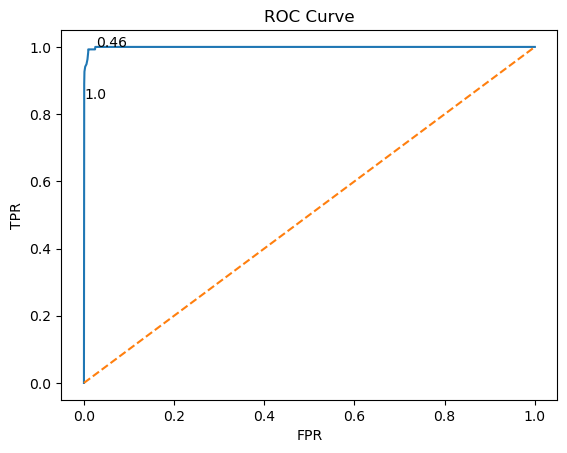

In [28]:
# Getting the probabilities of each outcome for the test set 
y_pred_prob_test = model_2.predict_proba(x_test_scaled)

# Getting the true positive rate and false postive rate from the testing set
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_test[:,1])

# Visualing the fpr and tpr 
plt.plot(fpr, tpr)
idx = list(range(len(threshold)))[1::20]
for i in idx:
    plt.text(fpr[i], tpr[i], threshold[i].round(2))
    
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(x_train_scaled, y_train_res)
roc_auc = roc_auc_score(y_test, clf.predict_proba(x_test_scaled)[:,1])

clf_fpr, clf_tpr, clf_threshold = roc_curve(y_test, clf.predict_proba(x_test_scaled)[:,1])
plt.plot(clf_fpr, clf_tpr, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [29]:
# Finding the roc auc score
roc_auc_score_ = roc_auc_score(y_test, y_pred_prob_test[:,1])
roc_auc_score_

0.999105556652191

In [30]:
# Finding the best threshold youlden stat
j_scores = tpr - fpr

# Youlden's J statistic
youlden_threshold = threshold[np.argmax(j_scores)]
print(youlden_threshold)

0.7804878048780488


In [31]:
# Creating a confusion matrix when the threshold is optimal tpr
y_pred_youlden = (y_pred_prob_test[:,1] > youlden_threshold)*1.0
cm_youlden = confusion_matrix(y_test, y_pred_youlden)
print(cm_youlden)

[[1771   17]
 [   2  134]]


In [32]:
# Getting the accuracy and recall score for the model at the youlden threshold
accuracy_youlden = accuracy_score(y_test, y_pred_youlden)
print('Accuracy score is ' + str(accuracy_youlden))

recall_youlden = recall_score(y_test, y_pred_youlden)
print('Recall score is ' + str(recall_youlden))

Accuracy score is 0.9901247401247402
Recall score is 0.9852941176470589


# Learning Curve

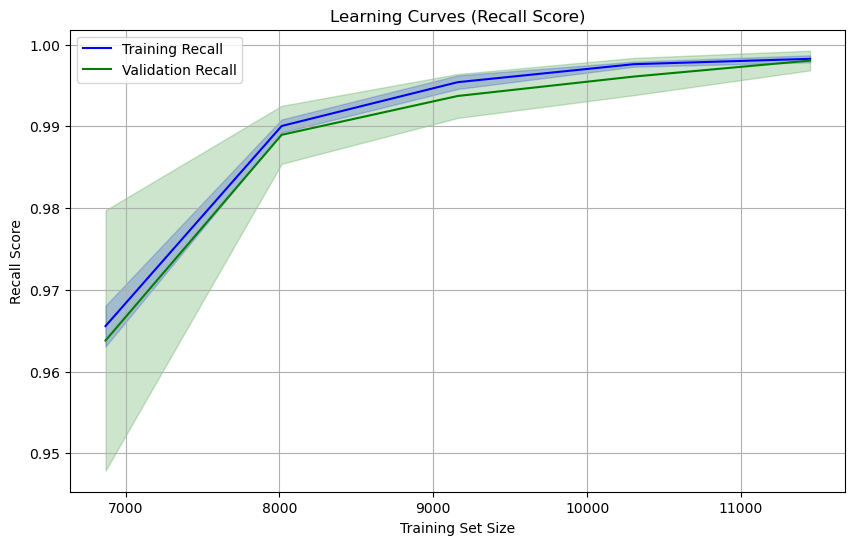

In [33]:
# Getting the learning curve data for the training and validation sets
train_sizes, train_scores, val_scores = learning_curve(model_2, x_train_scaled, y_train_res, cv=5, scoring='recall', 
                                                       train_sizes=np.linspace(0.1, 1.0, 10), random_state=1)

# Calculate the mean and std for the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Visualising the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Recall', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Recall', color='green')

# Filling below and above the mean by 1 std for the training and validation sets
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, color='green', alpha=0.2)

plt.title('Learning Curves (Recall Score)')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Making Predictions

In [34]:
# Features
# 'distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
# 'used_pin_number', 'online_order'

transaction_1 = np.array([10, 10, 1, 1, 0, 1, 0])
transaction_2 = np.array([20, 20, 2, 0, 1, 0, 1])
transaction_3 = np.array([50, 50, 3, 1, 0, 1, 0])
transaction_4 = np.array([100, 100, 5, 0, 0, 0, 1])

# Adding all the predictions into the same variable
fraud_pred = np.stack((transaction_1, transaction_2, transaction_3, transaction_4))

In [35]:
# Scaling the predictions so they match the model scale
fraud_pred = scaler.transform(fraud_pred)

In [36]:
# Using the model to get the predictions
print(model_2.predict(fraud_pred))
print(model_2.predict_proba(fraud_pred))

# Only transactions 4 was predicted to be fradulent

[0. 0. 0. 1.]
[[1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.02439024 0.97560976]]
